# Overview  <a name='objectives' />

This notebook introduces you to Support Vector Machines. 

The topics that will be covered are:

1. <a href=#svm_problem>The SVM Problem</a>
2. <a href=#kernels>Kernels</a>
3. <a href=#nu_svm>$\nu$-SVM (Advanced)</a>
4. <a href=#multiclass_svm>Multiclass SVM (Advanced)</a>
5. <a href=#sklearn>Sckit-Learn Implementation</a>

### Programming Tasks
For the programming tasks you will need to replace the following comment and exception with your own code:

```python
# YOUR CODE HERE
raise NotImplementedError()
```

Most programming tasks are followed by a cell with tests (using the `assert` function from python). You can use these cells while developing your implementation and for validating your implementation.

### Open Questions
The notebook also contains a few open questions. For the open questions you can put your answer in the cell below the question, replace the text "YOUR ANSWER HERE" with your own answer.

In [1]:
# Make sure that the required libraries are installed
# If you are using Google Colab, remember to upload the requirements file before 
# running this cell
# If you are running this notebook locally, the requirements file needs to be in 
# the same location as this notebook
import sys
!{sys.executable} -m pip install -r requirements_week05.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements_week05.txt'


In [0]:
from collections import namedtuple
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from sklearn.svm import SVC


In [0]:
# Counter for figures
figcount = 0

# Set the random seed for reproducing results
random_seed = 97 
np.random.seed(random_seed)

# Colors to use for plotting
colors = [plt.cm.Paired(3), plt.cm.Paired(1), plt.cm.Paired(5)]

# Data set namedtuple
DataSet = namedtuple("DataSet", ("X_train", "X_test", "y_train", "y_test"))

<a href=#objectives> [go to top] </a>
# Part 1: The SVM Problem <a name='svm_problem' />
The SVM optimization problem in matrix form is defined as follows:

$$\underset{\mathbf{a}}{\text{maximize}}\ \mathbb{1}_N^T\mathbf{a} - \frac{1}{2}\mathbf{a}^T\mathbf{P}\mathbf{a}$$
$$
\begin{split}
\text{subject to}\quad\quad a_i &\geq 0, \quad i=1,\ldots,N \\
\mathbf{y}^T \mathbf{a} &= 0
\end{split}
$$

with 

- $\mathbb{1}_N = [1, 1, \ldots 1]^T \in \mathbb{N}^{N}$
- $\mathbf{P} = (\mathbf{y}\mathbf{y}^T) \circ \mathbf{K}$, where $(\mathbf{y}\mathbf{y}^T)$ is the [*outer product*](https://en.wikipedia.org/wiki/Outer_product) and $\circ$ is the [*Hadamard product*](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)), also known as element wise matrix multiplication.
- $\mathbf{K}$ is the *Gram matrix*. 

The accompanying [qp_notation_svm.pdf](qp_notation_svm.pdf) shows the full derivation that was used to convert the original problem into matrix form.

First we are going to look at a binary classification problem in which the data is linearly separable in the input space $\mathbf{x}$ and where the dataset contains just four points. Most steps for this simple problem can be validated by hand, we highly recommend you do that.

The functions in part 1 will be used throughout the notebook.

In order to solve the SVM problem we are going to complete the following steps:
1. Define the linear kernel
2. Compute the Gram matrix $\mathbf{K}$ and Matrix $\mathbf{P}$
3. Solve the optmization problem to find $\mathbf{a}$
4. Compute the support vectors
5. Compute $\mathbf{w}$
6. Compute $b$
7. Define the decision function $f$ and a predictor for $y$

In [0]:
def get_test_data_set():
    X_train = np.array([[1, 1],
                        [2, 2],
                        [3, 3],
                        [4, 4]])
    
    y_train = np.array([-1, -1, 1, 1]) # For SVM we need target values {-1,+1} 
    X_test = np.array([[1.2, 2.3],
                       [2.5, 1.7],
                       [2.7, 3.2],
                       [3.5, 2.5]])
    y_test = np.array([-1, -1, 1, 1])
    
    return DataSet(X_train, X_test, y_train, y_test)

def plot_data(ax, data_set, legend='upper left'):
    X_train, X_test, y_train, y_test = data_set
    
    # Scatter plotting the data, filtering them according the pos/neg values
    for y in [-1, 1]:        
        ax.scatter(X_train[y_train == y, 0], X_train[y_train == y, 1], 
                   c=[colors[y]], 
                   s=30, 
                   label=r'$y={}$ (train)'.format(y))
        ax.scatter(X_test[y_test  == y, 0], X_test[y_test  == y, 1], 
                   c=[colors[y]], 
                   s=50, 
                   marker='x', 
                   label=r'$y={}$ (test)'.format(y))
    
    # Set Labels and Limits
    ax.set_xlabel(r'$x_0$')
    ax.set_ylabel(r'$x_1$')
    ax.set_xlim(min(X_train[:, 0].min(), X_test[:,0].min()) - 0.1, 
                max(X_train[:, 0].max(), X_test[:,0].max()) + 0.1)
    ax.set_ylim(min(X_train[:, 1].min(), X_test[:,1].min()) - 0.1, 
                max(X_train[:, 1].max(), X_test[:,1].max()) + 0.1)
    
    # Legend
    if legend is not None:
        pst = ax.legend(loc=legend, frameon=True)
        pst.get_frame().set_edgecolor('k')

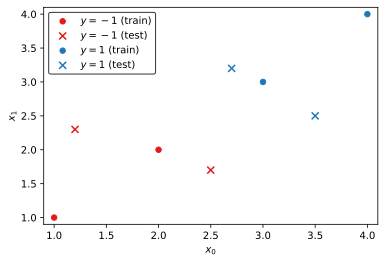

In [22]:
# Get data set
test_data_set = get_test_data_set()

# Plot data
plt.figure()
ax = plt.gca()
plot_data(ax, test_data_set)

### Task 1.1: Linear Kernel
It is clear that the data is linearly separable in the input space $\mathbf{x}$. Therefore we do not need to transform our data using some feature mapping, i.e., $\phi(\mathbf{x}) = \mathbf{x}$. The *linear kernel* is the kernel associated with $\phi(\mathbf{x}) = \mathbf{x}$. The first task is to derive the linear kernel and write a function that computes it.

In [0]:
def linear_kernel(x_i, x_j):
    """
    Compute the linear kernel between two arrays of data.
    
    :param x_i: (type: numpy array)
    :param x_j: (type: numpy array)
    :returns:   linear kernel, (type: float or numpy array)
    """
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    k = np.dot(x_i, x_j.T)
    return k
    

In [24]:
x_i = np.array([1, 2, 3])
x_j = np.array([1, 1, 1])

assert linear_kernel(x_i, x_i) == 14
assert linear_kernel(x_i, x_j) == 6
assert linear_kernel(x_j, x_j) == 3


print(linear_kernel(x_i,x_j))

6


### Task 1.2: Gram Matrix and Matrix P
Now that we have our kernel we can start defining our optimization problem. For that we need tot compute the Gram matrix $\mathbf{K}$ and the matrix $\mathbf{P} = (\mathbf{y}\mathbf{y}^T) \circ \mathbf{K}$.

In [0]:
def compute_gram_matrix(X, kernel=linear_kernel):
    """
    Compute the Gram matrix as defined in the slides and the associated pdf.
    
    Remember that X = [x[0], x[1], ..., x[N]]^T
    
    :param X:      training values (type: numpy array of shape (N, n_features))
    :param kernel: kernel (type: function or callable object)
    :returns:      Gram matrix (type: numpy array of shape (N, N))
    """
    
    # YOUR CODE HERE
    K = np.dot(X.T,X)
    return K

In [0]:
def compute_P(K, y):
    """
    Compute matrix P.
    
    :param K: Gram matrix (type: numpy array of shape (N, N))
    :param y: target values (type: numpy array of shape (N,))
    :returns: matrix P (type: numpy array of shape(N, N))
    """
    
    # YOUR CODE HERE
    #raise NotImplementedError()
    a = np.dot(y,y.T)
    P = K.dot(a)
    return P

In [40]:
K_true = np.asarray([[2,  4,  6,  8],
                     [4,  8, 12, 16],
                     [6, 12, 18, 24],
                     [8, 16, 24, 32]])
P_true = np.asarray([[ 2,   4,  -6,  -8],
                     [ 4,   8, -12, -16],
                     [-6, -12,  18,  24],
                     [-8, -16,  24,  32]])

K = compute_gram_matrix(test_data_set.X_train, linear_kernel)
print("K:")
print(K)

P = compute_P(K, test_data_set.y_train)
print("\nP:")
print(P)

assert np.allclose(K, K_true)
assert np.allclose(P, P_true)

K:
[[30 30]
 [30 30]]

P:
[[120 120]
 [120 120]]


ValueError: ignored

### Task 1.3: Solving the Optimization
Now it is time to do solve the SVM optimization problem using the functions you have defined above. Remember that the optmization problem is:

$$\underset{\mathbf{a}}{\text{maximize}}\ \mathbb{1}_N^T\mathbf{a} - \frac{1}{2}\mathbf{a}^T\mathbf{P}\mathbf{a}$$
$$
\begin{split}
\text{subject to}\quad\quad a_i &\geq 0, \quad i=1,\ldots,N \\
\mathbf{y}^T \mathbf{a} &= 0
\end{split}
$$

We don't want you to be spending to much time on having to figure out the `cvxpy` library, therefore the `optimize_svm` function is given. Go through the code to validate for your self what is happening and what each function means. Also have a look at the [cvxpy documentation](https://www.cvxpy.org/) or use the build in documentation viewer (run cell below for example).

In [0]:
cp.quad_form?

In [0]:
def optimize_svm(X, y, kernel=linear_kernel):
    """
    Solves the the quadratic programming problem.
    
    The optimization does not always succeed, this can
    have several causes. 
    
    When you get the error that the problem is not DCP 
    we recommend trying different hyperparameters or a 
    different kernel. Often the reason for this problem
    is that the data is not linearly separable in the 
    feature space.
    
    Another error that can occur is that the solver
    was not able to find a solution. In this case, run
    the optimization again. Sometimes it was just some
    initialization error within the solver. If the solver
    keeps failing to solve the problem you have to change
    the hyperparameters or kernel.
    
    The main reason for problems however is wrongly 
    implemented methods. So step one should always be,
    check your implementation.
    
    :param X:      training values (type: numpy array of shape (N, n_features))
    :param y:      target values (type: numpy array of shape (N,))
    :param kernel: kernel function (type: function or callable object)
    :returns:      Lagrangian multipliers (type: numpy array of shape (N,))
                   None if optimization fails
    """
    N = y.shape[0]
    
    K = compute_gram_matrix(X, kernel)
    P = compute_P(K, y)
    P = 0.5 * (P + P.T) # make sure P is symmetric, increases stability of optimization
    
    a = cp.Variable((N,1))
    L = cp.sum(a) - 0.5 * cp.quad_form(a, P) 
    
    constraints = [a >= 0, 
                   a.T * y == 0]

    objective = cp.Maximize(L)
    prob = cp.Problem(objective, constraints)

    prob.solve(solver='ECOS')
    
    if a.value is None:
        print("No solution could be found, is the data linearly separable in the feature space?")
        return None
    else:
        return a.value.reshape((-1,))

In [42]:
a = optimize_svm(test_data_set.X_train, test_data_set.y_train, linear_kernel)

print("a:", a)

assert np.allclose(a, [0, 1, 1, 0])

Exception: ignored

### Task 1.4: Computing the Support Vectors

##### Note on Numerical Values:
Since we are working with numerical optimization, results
will have small errors and cannot be compared directly. We 
can work around this problem by using small thresholds. 

For example:
We have a true value `y = 1` and some numerical optimization 
calculates an estimate `yhat = 1.0000001` for `y`. Comparing 
using `y == yhat` gives back `False`. Instead we can use
`abs(y - yhat) < threshold` to circumvent the problem.

In [0]:
def compute_svi(a, threshold=1e-5):
    """
    Compute the indices of the support vectors.   
    
    :param a:         Lagrange multipliers (type: numpy array of shape (N,))
    :param threshold: threshold value (type: float)
    :returns:         indices of the support vectors (type: numpy array of shape (S,))
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()
    svi = SVC(C = 1e5, kernel = 'linear')
    svi.fit(a,y)
    svi.support(a)
    return svi

In [53]:
svi = compute_svi(a)
print("svi:", svi)

support_vectors = test_data_set.X_train[svi]
print("support vectors:")
print(support_vectors)

assert np.allclose(svi, [1, 2])

NameError: ignored

### Question 1: what do support vectors represent?
The SVM tries to find a decision boundary that separates two classes with the widest margin. For points on the decision boundary we know that the decision function equals zero:

$$f(\mathbf{x}) = \mathbf{w}^T\phi(\mathbf{x}) + b = 0$$

What is the value of the decision function for the support vectors?

YOUR ANSWER HERE

### Task 1.5: Computing $\mathbf{w}$
Remember from the VO that we can find an expression for $\mathbf{w}$ by solving:

$\frac{\partial L}{\partial \mathbf{w}} = 0$

(This does require the formulation of $L$ that contains the variable $\mathbf{w}$, see the VO slides for more info)

In [0]:
def compute_w(a, y, X):
    """
    Compute weight vector w
    
    :param a: Lagrange multipliers (type: numpy array of shape (N,))
    :param y: target values (type: numpy array of shape(N,))
    :param x: training vectors (type: numpy array of shape(N, n_features))
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return w

In [0]:
w = compute_w(a, test_data_set.y_train, test_data_set.X_train)
print("w:", w)

assert np.allclose(w, [1, 1])

### Task 1.6: Computing $b$
The decision function is defined as:

$$f(\mathbf{x}) = \mathbf{w}^T\phi(\mathbf{x}) + b$$

for the support vectors $\mathbf{x}_s \in \mathcal{S}$, where $\mathcal{S}$ denotes the set of all support vectors, we know that: 

$$f(\mathbf{x_s}) = \mathbf{w}^T\phi(\mathbf{x_s}) + b = y_s$$ 

the values for $\mathbf{w}$ and $\mathbf{x}_s$ are known, so we can solve for $b$:

$$b = y_s - \mathbf{w}^T\phi(\mathbf{x_s})$$

But which support vector $\mathbf{x}_s$ do we use? It turns out that just using one value might result in stability issues. A commonly used solution is to average over all support vectors $\mathcal{S}$:

$$b = \frac{1}{|\mathcal{S}|}\sum_{i \in \mathcal{S}}y_i - \mathbf{w}^T\phi(\mathbf{x}_i)$$

One more issue remains, our expression for $b$ contains the feature $\phi(\mathbf{x}_i)$. One nice property of SVMs is that the feature mapping $\phi$ does not have to be known, but only a kernel $k(\mathbf{x}_i, \mathbf{x}_j)$ that is valid for $\phi$.



### Question 2: What is an advantage of using $k$ instead of $\phi$?
Remember that a kernel function is defined as $k(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^T\phi(\mathbf{x}_j)$. Tip: how does the feature mapping $\phi$ of, for example, $k(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i^T\mathbf{x}_j)^2$ look?

YOUR ANSWER HERE

Rewrite the expression for $b$ into a form that uses the kernel function $k(\mathbf{x}_i, \mathbf{x}_j)$ instead of $\phi(\mathbf{x}_i)$. Use the rewritten expression in the tasks below.

In [0]:
def compute_b(a_sv, y_sv, support_vectors, kernel=linear_kernel):
    """
    Compute the bias variable `b` using the averaging approach.
    
    :param a_sv:            lagrange multipliers corresponding to the support vectors 
                            (type: numpy array of shape (n_support_vectors,))
    :param y_sv:            target values corresponding to the support vectors
                            (type: numpy array of shape (n_support_vectors,))
    :param support_vectors: support vectors (type: numpy array of shape (n_support_vectors, n_features))
    :param kernel:          kernel (type: function or callable object)
    :returns:               bias variable (type: float)
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return b

For a linear kernel the feature mapping is particularly easy: $\phi(\mathbf{x}) = \mathbf{x}$. We will use this for evaluating the function `compute_b` by comparing the results with the expression:

$$b = \frac{1}{|\mathcal{S}|}\sum_{i \in \mathcal{S}}y_i - \mathbf{w}^T\mathbf{x}_i$$

Solve this exercise by hand an add the solution in the cell below:

In [0]:
def b_features():
    """
    Return the value you found by solving the equation above.
    
    Simply write `return VALUE_FOR_B`
    
    :returns: bias b (type: float)
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()

In [0]:
a_sv = a[svi]
y_sv = test_data_set.y_train[svi]

b = compute_b(a_sv, y_sv, support_vectors, linear_kernel)
print("b:", b)

assert abs(b - b_features()) < 1e-5

### Task 1.7: Decision Function and Prediction 
We now have all the components for our model, the next step is to use them for making predictions. We split the prediction into two parts, first part is the decision function $f$. The predictor can use the decision function for making predictions. We will also define an accuracy metric for evaluating the accuracy of our model on a test set.

In [0]:
def decision_function(x, a, y, X, b, kernel=linear_kernel):
    """
    The decision function tells us on which side of the decision boundary 
    generated by `f` a sample `x` is located
    
    :param x:      input sample (type: numpy array of shape (n_features,))
    :param a:      lagrange multipliers (type: numpy array of shape (M,))
    :param y:      target values (type: numpy array of shape (M,))
    :param X:      training values (type: numpy array of shape(M, n_features))
    :param b:      bias variable (type: float)
    :param kernel: kernel (type: function or callable object)
    :returns:      decision function value (type: float)
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return f
    
    
def predict(x, a, y, X, b, kernel=linear_kernel):
    """
    Predicts the target value `y=1` or `y=-1` for a sample `x`.
    
    Tip: use the decision function defined above.
    
    :param x:      input sample (type: numpy array of shape (n_features,))
    :param a:      lagrange multipliers (type: numpy array of shape (M,))
    :param y:      target values (type: numpy array of shape (M,))
    :param X:      training values (type: numpy array of shape(M, n_features))
    :param b:      bias variable (type: float)
    :param kernel: kernel (type: function or callable object)
    :returns:      prediction yhat={-1, 1} (type: int or float)
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return yhat


def accuracy(y, yhat):
    """
    Calculates the accuracy as the number of correctly predicted
    target divided by the total number of predictions.
        
    :param y:    actual target values (type: numpy array of shape (M,))
    :param yhat: predicted target values (type: numpy array of shape(M,))
    :returns:    accuracy score (type: float)
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return score

In [0]:
X_train, X_test, y_train, y_test = test_data_set
f_test = np.asarray([-1.5, -0.8, 0.9, 1.])

# Get values decision function
f = decision_function(X_test, a, y_train, X_train, b, linear_kernel)
print("f:", f)

# Get values prediction
y_pred = predict(X_test, a, y_train, X_train, b, linear_kernel)
print("y:", y_pred)

# Validate accuracy
score = accuracy(y_test, y_pred)
print("score:", score)

assert np.allclose(f, f_test)
assert np.allclose(y_pred, y_test)
assert abs(score - 1.0) < 1e-5

### Question 3: Should we use `a`, `y` and `X`  or `sv_a`, `sv_y` and `support_vectors`?
Lets look at the following functions we have defined in the previous tasks: `compute_w`, `compute_b`, `decision_function` and `predict`. 

When we computed $b$ it is clear from the theory we have to use the support vectors (`support_vectors`, `sv_a` and `sv_y`). But when we called the other three functions we used the full dataset (`X`, `a` and `y`), wouldn't it be enough to only use the support vectors for these three functions as well? Motivate your answer.

YOUR ANSWER HERE

We now have now have all everything for our SVM classifier. Let's see what the classifier has learned by updating our figure. Plotting results is useful for interpretating what your model has actually learned, especially during development and implementation of your method. For high dimensional data this becomes difficult of course.

In the plots, *dots* indicate training data and *stars* test data. The decision boundary is denoted be a *black line* and the *widest margin* by dotted lines. You don't have to understand how al the functions for generating the plots work.

In [0]:
plt.figure()
ax = plt.gca()

# Plot data
plot_data(ax, test_data_set)

# plot support vectors
ax.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

# plot the decision function

xlim = ax.get_xlim()
ylim = ax.get_ylim()

## create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

margins = []
for _x in xy:
    margins.append(decision_function(_x, a_sv, y_sv, support_vectors, b))
margins = np.asarray(margins).reshape(XX.shape)
Z = np.zeros(margins.shape)
Z[margins < 0] = -1
Z[margins >= 0] = 1

## plot decision boundary and margins   
ax.contour(XX, YY, margins, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
ax.contourf(XX, YY, Z, alpha=0.1, colors=[colors[-1], colors[1]])

The *black line* is our decision boundary, all samples above the line get $y=1$ (brown) from our predictor and all values below the line $y=-1$ (blue). The *dashed line* indicates the margin of our classifier, i.e., $f(\mathbf{x}) = 1$, and our support vectors will lay on those lines, the support vectors are *encircled*. The *stars* are our test samples, which have been classified correctly.

## Combining All the Parts
In order to make working with our classifier we have combined all the parts into one class for you. For the rest of the notebook we will be using this class for constructing classifiers.

In [0]:
class SVM:
    
    def __init__(self, kernel, threshold=1e-5):
        self.kernel = kernel
        self.threshold = threshold
        
        self.svi = None
        self.support_vectors = None
        self.sv_y = None
        self.sv_a = None
        self.w = None
        self.b = None
        
    def optmize(self, X, y):
        return optimize_svm(X, y, self.kernel)
        
    def fit(self, X, y):        
        # Perform optmization
        a = self.optmize(X, y)
        if a is None:
            return False
        
        # Determine support vectors (a != 0)
        self.svi = compute_svi(a)
        
        # Store support vector variables we need later
        self.support_vectors = X[self.svi]
        self.sv_y = y[self.svi]
        self.sv_a = a[self.svi]
        
        # Compute w
        self.w = compute_w(self.sv_a, self.sv_y, self.support_vectors)

        # Compute b
        self.b = compute_b(self.sv_a, self.sv_y, self.support_vectors, kernel=self.kernel)
        
        return True
        
    def decision_function(self, x):
        if self.b is None:
            print("Model has not been trained yet, first run '{}.fit(X, y)'".format(self.__class__.__name__))
            return None
        
        return decision_function(x, self.sv_a, self.sv_y, self.support_vectors, self.b, kernel=self.kernel)
    
    def predict(self, x):
        if self.b is None:
            print("Model has not been trained yet, first run '{}.fit(X, y)'".format(self.__class__.__name__))
            return None
        
        return predict(x, self.sv_a, self.sv_y, self.support_vectors, self.b, kernel=self.kernel)
    
    def score(self, x, y):
        if self.b is None:
            print("Model has not been trained yet, first run '{}.fit(X, y)'".format(self.__class__.__name__))
            return None
        
        yhat = self.predict(x)
        return accuracy_score(y, yhat)
    
    def plot_decision_boundary(self, ax):
        # plot support vectors
        ax.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1], s=100,
                   linewidth=1, facecolors='none', edgecolors='k')
        
        # plot the decision function
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        ## create grid to evaluate model
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        
        margins = []
        for _x in xy:
            margins.append(self.decision_function(_x))
        margins = np.asarray(margins).reshape(XX.shape)
        Z = np.zeros(margins.shape)
        Z[margins < 0] = -1
        Z[margins > 0] = 1
         
        ## plot decision boundary and margins   
        ax.contour(XX, YY, margins, colors='k', levels=[-1, 0, 1], alpha=0.5,
                       linestyles=['--', '-', '--'])
        ax.contourf(XX, YY, Z, alpha=0.1, colors=[colors[-1], colors[1]])
                

### Example using SVM Class

In [0]:
np.random.seed(231)
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i in range(4):
    print("Solving for data set {}".format(i))
    # Generate random data
    X, y = make_blobs(40, centers=2, random_state=i+1)
    y[y == 0] = -1
    
    # Split data into train and test set
    data_set = DataSet(*train_test_split(X, y, test_size=0.3))
        
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper left' if i == 0 else None
    plot_data(ax, data_set, legend)
        
    # Create SVM with linear kernel
    svm = SVM(kernel=linear_kernel)
    
    # Fit the data
    success = svm.fit(data_set.X_train, data_set.y_train)
    if not success:
        continue
    
    # Validate on test set  
    score = svm.score(data_set.X_test, data_set.y_test)
        
    # Plot margins and predictions
    svm.plot_decision_boundary(ax)
    
    pad_text = -0.2
    ax.text(0.5, pad_text, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.075, "# support vectors: {}".format(len(svm.svi)), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.15, "w: {}".format(svm.w), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.225, "b: {:.2}".format(svm.b), size=12, ha="center", transform=ax.transAxes)

<a href=#objectives> [go to top] </a>
# Part 2: Kernels <a name='kernels' />
So far we have only looked at data that is linearly separable in the input space $\mathbf{x}$. But in most data sets that won't be the case, but it might be that the data is linearly separable in some higher dimensional space obtained using a feature mapping $\phi$. Thanks to the *kernel trick* we don't have to actually transform our data into this high dimensional feature space, but instead only need the associated kernel function.

Lets first generate some need data sets, which we will simply call data set `0` and data set `1`.

In [0]:
np.random.seed(1)
n_samples = 500
data_sets_kernels = []

def add_to_data_sets(X, y):
    y[y == 0] = -1
    data_set = DataSet(*train_test_split(X, y, test_size=0.3))
    data_sets_kernels.append(data_set)

X, y = make_circles(n_samples, factor=0.5, noise=0.07)
add_to_data_sets(X, y)

X, y = make_moons(n_samples, noise=0.1)
add_to_data_sets(X, y)

In [0]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_kernels):        
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper right' if i == 1 else None
    plot_data(ax, data_set, legend)
    ax.text(0.5, -0.2, "data set: {}".format(i), size=12, ha="center", transform=ax.transAxes)

### Task 2.1: Implement the Gaussian and Polynomial Kernel


In [0]:
class GaussianKernel:
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def __call__(self, x_i, x_j):
        """
        Compute the Gaussian kernel between two vectors.
        
        The `__call__` method allows us to use instantiated classes as if
        they are functions:
        
          gaussian_kernel = GaussianKernel(0.5)
          k = gaussian_kernel(x_i, x_j)
          
        
        :param x_i: (type: numpy array)
        :param x_j: (type: numpy array)
        :returns:   Gaussian kernel (type: float or numpy array)
        """
        
        # YOUR CODE HERE
        raise NotImplementedError()
        
        return k
    
class PolynomialKernel:
    
    def __init__(self, c, degree):
        self.c = c
        self.degree = degree
        
    def __call__(self, x_i, x_j):
        """
        Compute the polynomial kernel between two vectors.
        
        
        :param x_i: (type: numpy array)
        :param x_j: (type: numpy array)
        :returns:   Polynomial kernel (type: float or numpy array)
        """
        
        # YOUR CODE HERE
        raise NotImplementedError()
        
        return k

In [0]:
gaussian_kernel = GaussianKernel(sigma=1.0)

assert abs(gaussian_kernel(np.array([1, 2]), np.array([1, 2])) - 1.0) < 1e-3
assert abs(gaussian_kernel(np.array([1, 1]), np.array([0, 0])) - 0.368) < 1e-3

In [0]:
polynomial_kernel = PolynomialKernel(c=2.0, degree=3)

assert abs(polynomial_kernel(np.array([0, 0]), np.array([1, 0])) - 8.0) < 1e-3
assert abs(polynomial_kernel(np.array([1, 2]), np.array([1, 1])) - 125.0) < 1e-3

### Task 2.2: Proof That the Polynomial Kernel is a Valid Kernel
During the exercise session of the VO you had to prove that the Gaussian kernel is a valid kernel. Do the same for the polynomial kernel with `degree=2.0` and abitrary `c`. Derive the associated feature mapping $\phi({\mathbf{x}})$ and write a function to compute the feature mapping. The function should accept an abitrary size for input vector $\mathbf{x}$.

Tip: first find the solution on a piece of paper when using $\mathbf{x_i} = [x_1, x_2]$ and $\mathbf{x_j} = [z_1, z_2]$. And then solve for $\mathbf{x_i} = [x_1, x_2, x_3]$ and $\mathbf{x_j} = [z_1, z_2, z_3]$. Look for a pattern.

In [0]:
def compute_polynomial_feature(x, c):
    """
    Compute second degree polynomial feature.
    
    :param x: input sample (numpy array of shape (n_features_1,))
    :param c: constant (type: float)
    :returns: polynomial feature (type: numpy array of shape (n_features_2,))
    """
    degree = 2
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return phi

In [0]:
c = 2.0
polynomial_kernel = PolynomialKernel(c=c, degree=2)

for i in range(3):
    x = np.arange(1, i+3)
    phi = compute_polynomial_feature(x, c)
    print("")
    print("x_{}:".format(i), x)
    print("phi(x_{}):".format(i), phi)
    
    assert abs(np.dot(phi, phi) - polynomial_kernel(x, x)) < 1e-5

### Task 2.3: Choosing Appropriate Kernels
Return the appropriate kernel for each dataset in the function `choose_kernel` below.

In [0]:
def choose_kernel(data_set_id):
    """
    Return an appropriate kernel for each data set.
    
    Don't forgot to instantiate your kernel before returning and
    choose appropriate hyper parameters:
    
      gaussian_kernel = GaussianKernel(sigma)
      return gaussian_kernel
    
    :param data_set_id: for which data set to return the kernel (type: int)
    """
    if data_set_id == 0:
        
        # YOUR CODE HERE
        gaussian_kernel = GaussianKernel(sigma = 1.0)
        return gaussian_kernel
        #raise NotImplementedError()
        
    if data_set_id == 1:
        
        # YOUR CODE HERE
        polynomial_kernel = PolynomialKernel(c=2,degree=3)
        #raise NotImplementedError()
        

In [0]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_kernels):
    print("solving for dataset {}".format(i))
    
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper right' if i == 1 else None
    plot_data(ax, data_set, legend)
        
    # Create SVM
    kernel = choose_kernel(i)
    svm = SVM(kernel)
    
    # Fit the data
    success = svm.fit(data_set.X_train, data_set.y_train)
    if not success:
        continue
    
    # Validate on test set    
    score = svm.score(data_set.X_test, data_set.y_test)
        
    # Plot Results
    svm.plot_decision_boundary(ax)
    
    pad_text = -0.2
    ax.text(0.5, pad_text, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.075, "# support vectors: {}".format(len(svm.svi)), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.15, "w: {}".format(svm.w), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.225, "b: {:.2}".format(svm.b), size=12, ha="center", transform=ax.transAxes)

<a href=#objectives> [go to top] </a>
# Part 3: $\nu$-SVM (Advanced)<a name='nu_svm' />
So far we have seen data sets that are linearly seperable in some feature space generated by a mapping $\phi$. In real data this will often be the case, and the data overlaps or contains some outlier. The standard SVM implementation imposes strict margins, instead we would like to have soft-margins that can deal with this type of data. 

In other words, for strict margins we want the training data of one class to be strictly on one side of the decision boundary and the other class on the other side and no samples within the margins. For soft margins, we say it is ok if some data samples in our training set are on the wrong side of the boundary or within the margin.

One such algorithm is the $\nu$-SVM. As discussed in the VO, the $\nu$-SVM problem is defined as follows:

$$\underset{\mathbf{a}}{\text{maximize}}\ \mathbb{1}_N^T\mathbf{a} - \frac{1}{2}\mathbf{a}^T\mathbf{P}\mathbf{a}$$

subject to:

$$
\begin{split}
0 \leq a_i &\leq \frac{1}{N}, \quad i=1,\ldots,N \\
\mathbf{y}^T \mathbf{a} &= 0 \\
\mathbb{1}_N^T\mathbf{a} &\geq \nu
\end{split}
$$

In [0]:
np.random.seed(231)
n_samples = 100
data_sets_nu = []

for i in range(2):
    # Generate random data
    X, y = make_blobs(100, centers=2, random_state=i+7, cluster_std=2.7)
    y[y == 0] = -1
    data_set = DataSet(*train_test_split(X, y, test_size=0.3))
    data_sets_nu.append(data_set)

In [0]:
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_nu):
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper left' if i == 0 else None
    plot_data(ax, data_set, legend)
    ax.text(0.5, -0.2, "data set: {}".format(i), size=12, ha="center", transform=ax.transAxes)

### Task 3.1: Update the SVM Optimization to $\nu$-SVM
Write the new constraints for the $\nu$-SVM in the `optimize_nu_svm` function below.

In [0]:
def optimize_nu_svm(X, y, nu, kernel=linear_kernel):
    """
    
    :param X:      training values (type: numpy array of shape (N, n_features))
    :param y:      target values (type: numpy array of shape (N,))
    :param nu:     provides bounds on the support vectors, value has to be in interval (0, 1]
                   (type: float)
    :param kernel: kernel (type: function or callable object)
    :returns:      Lagrangian multipliers (type: numpy array of shape (N,))
                   None if optimization fails
    """
    if nu <= 0 or nu > 1:
        raise ValueError("nu={} is invalid, value to be in interval (0, 1]".format(nu))
    
    K = compute_gram_matrix(X, kernel)
    P = compute_P(K, y)
    P = 0.5 * (P + P.T) # make sure P is symmetric, increases stability of optimization
    
    N = y.shape[0]
    a = cp.Variable((N,1))
    L = cp.sum(a) - 0.5 * cp.quad_form(a, cp.Constant(P)) 
    
    """
    Write the appropriate constraints for the nu-SVM problem. 
    
    Previous constraints were:
    
      constraints = [a >= 0, 
                     a.T * y == 0]
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()

    objective = cp.Maximize(L)
    prob = cp.Problem(objective, constraints)

    prob.solve()
    
    if a.value is None:
        print("No solution could be found, is the data linearly separable in the feature space?")
        return None
    else:
        return a.value.reshape((-1,))

In [0]:
class NuSVM(SVM):
    """
    We can inherit almost all the functions from our original SVM class.
    Only the optmization function has changed.
    """
    
    def __init__(self, nu, kernel):
        super(NuSVM, self).__init__(kernel)
        self.nu = nu
        
    def optmize(self, X, y):
        return optimize_nu_svm(X, y, self.nu, self.kernel)

In [0]:
np.set_printoptions(precision=2)
plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(2, 2)
gs.update(wspace=0.2, hspace=0.5)

for i, data_set in enumerate(data_sets_nu):
    print("Solving for data set {}".format(i))
    
    # Plot data
    ax = plt.subplot(gs[i])
    legend = 'upper left' if i == 0 else None
    plot_data(ax, data_set, legend)
        
    # Create SVM with linear kernel
    svm = NuSVM(nu=0.5, kernel=linear_kernel)
    
    # Fit the data
    success = svm.fit(data_set.X_train, data_set.y_train)
    if not success:
        break
    
    # Validate on test set  
    score = svm.score(data_set.X_test, data_set.y_test)
    
    # Plot margins and predictions
    svm.plot_decision_boundary(ax)
    
    pad_text = -0.2
    ax.text(0.5, pad_text, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.075, "# support vectors: {}".format(len(svm.svi)), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.15, "w: {}".format(svm.w), size=12, ha="center", transform=ax.transAxes)
    ax.text(0.5, pad_text-0.225, "b: {:.2}".format(svm.b), size=12, ha="center", transform=ax.transAxes)

<a href=#objectives> [go to top] </a>
# Part 4: Multiclass SVM (Advanced) <a name='multiclass_svm' />
In the last part of this notebook we will be implementing a simple implementation to solve the multiclass SVM problem and evaluate on the iris data set. 

In [0]:
from sklearn.datasets import load_iris

iris_data_set = load_iris()
y = iris_data_set['target']

# Select the 'RM' and 'LSTAT' columns from the dataset
used_features = ['sepal length (cm)', 'petal length (cm)']
data_col = list()
for col, val in enumerate(iris_data_set['feature_names']):
    if(val in used_features):
        data_col.append(col)

X = iris_data_set['data'][:,data_col]
data_set_iris = DataSet(*train_test_split(X, y, test_size=0.3))

In [0]:
def plot_iris_dataset(ax, data_set_iris, x_label = 'sepal length (cm)', y_label = 'sepal width (cm)'):
    X_train, X_test, y_train, y_test = data_set_iris
    
    # Scatter plotting the data, filtering them according the pos/neg values
    for i, label in enumerate(['setosa', 'versicolour', 'virginica']):
        idx_train = y_train == i
        idx_test = y_test == i

        ax.scatter(X_train[idx_train, 0], X_train[idx_train, 1], s=30, c=[colors[i]], label='{} (train)'.format(label))
        ax.scatter(X_test[idx_test, 0], X_test[idx_test, 1], c=[colors[i]], s=50, marker='x', label='{} (test)'.format(label))

    # Labels and limits
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_xlim(X[:, 0].min()-0.1, X[:, 0].max()+0.1)
    ax.set_ylim(X[:, 1].min()-0.1, X[:, 1].max()+0.1)

    # Legend
    pst = ax.legend(loc='lower right', frameon=True)
    pst.get_frame().set_edgecolor('k')
    

def plot_decision_boundary(ax, predict_function):        
    # plot the decision function
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 100)
    yy = np.linspace(ylim[0], ylim[1], 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = []
    for _x in xy:
        Z.append(predict_function(_x.reshape(1, -1)))
    Z = np.asarray(Z).reshape(XX.shape)

    # plot decision boundary 
    ax.contourf(XX, YY, Z, levels=2, colors=colors, alpha=0.1)
    ax.contour(XX, YY, Z, levels=2, colors=colors, alpha=1)

In [0]:
plt.figure(figsize=(7,5))
ax = plt.gca()
plot_iris_dataset(ax, data_set_iris)

### Task 4.1: Implement Multiclass SVM
One method for solve the multiclass SVM problem is the "one versus the rest" approach as explained in the lecture:

1. Construct $M$ separate SVMs.
2. The $m$-th model $f_m(\mathbf{x})$ is trained using data from class $C_m$ as positive examples ($y_m = +1$) and the data from the remaining $M - 1$ classes as negative samples $y_{i \neq m} = -1$.
3. Train each model separately.

For prediction return the class label associated with the model $m$ that returns a positive prediction ($+1$).

In [0]:
class MulticlassSVM:
    
    def __init__(self, nu, kernel):
        self.nu = nu
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Implement the training procedure for the Multiclass SVM.
        
        :param X: training values (type: numpy array of shape (N, n_features))
        :param y: target values (type: numpy array of shape (N,))
        :returns: True if successful, False otherwise (type: bool)
        """
        
        # YOUR CODE HERE
        raise NotImplementedError()
        
        return True
        
    def predict(self, x):
        """
        Implement the predictor for the Multiclass SVM.
        
        :param x: input sample (type: numpy array of shape (n_features,))
        :returns: predicted class (type: int)
        """
        
        # YOUR CODE HERE
        raise NotImplementedError()
        
        return yhat
        
    def score(self, x, y):
        yhat = self.predict(x)
        return accuracy_score(y, yhat)

In [0]:
def return_multiclass_svm_iris(data_set_iris):
    """
    Create a Multiclass SVM trained on the iris data set.
    
    Choose appropriate hyperpameter values and kernels. Play 
    around and find some solution that solves the problem
    
    :param data_set_iris: the iris data set variable (type: DataSet)
    :returns:             trained MulticlassSVM (type: MulticlassSVM)
    """
    X_train, _, y_train, _ = data_set_iris
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return svm

In [0]:
multiclass_svm = return_multiclass_svm_iris(data_set_iris)
score = multiclass_svm.score(data_set_iris.X_test, data_set_iris.y_test)

plt.figure(figsize=(7,5))
ax = plt.gca()
plot_iris_dataset(ax, data_set_iris)
plot_decision_boundary(ax, multiclass_svm.predict)
_ = ax.text(0.5, -0.2, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)

### Question 4: What is a Limitation of the "One Versus All" approach?
And can you come up with a modification to overcome this limitation?

YOUR ANSWER HERE

<a href=#objectives> [go to top] </a>
# Scikit-Learn Implementation <a name='sklearn' />

In [0]:
from sklearn.svm import SVC
# Scikit learn has a different default SVM implementation called C-Support Vector Classification
sk_svm = SVC(C=100000, kernel='poly', degree=2) 

sk_svm.fit(data_set_iris.X_train, data_set_iris.y_train)
score = sk_svm.score(data_set_iris.X_test, data_set_iris.y_test)

plt.figure(figsize=(7,5))
ax = plt.gca()
plot_iris_dataset(ax, data_set_iris)
plot_decision_boundary(ax, sk_svm.predict)
_ = ax.text(0.5, -0.2, "accuracy: {:.2}".format(score), size=12, ha="center", transform=ax.transAxes)